In [1]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from io import StringIO
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
import nltk
import pandas as pd
import re
import string

nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
app_reviews_df = pd.read_csv("https://raw.githubusercontent.com/muhammadelfikry/Sentimen-Analisis-Review-APK-PINTU/refs/heads/main/dataset/ulasan_aplikasi.csv")
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,d2242e96-2d98-4e73-a107-72011c8d63a5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,baru Join dan ngerasa sangat membantu untuk pe...,5,7,3.71.0,2025-04-26 04:29:58,"Hi Kak, terimakasih atas review dan komentar p...",2025-04-26 08:05:13,3.71.0
1,73c7d371-4d4d-47e4-9321-80bbf6c241f5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Maaf saya harus kasih b1, karena aplikasi ini ...",1,5,3.71.0,2025-04-26 09:05:17,"Hi Kak, kami mohon maaf atas kendala yang Kaka...",2025-04-26 15:14:35,3.71.0
2,f6fd7a0a-578f-4d7b-bc3f-b82f877e2a67,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sebagai pemula di dunia kripto, gue ngerasa Pi...",5,11,3.71.0,2025-04-22 18:44:38,"Hi Kak, terima kasih atas review dan komentar ...",2025-04-22 22:26:49,3.71.0
3,7ee5925a-ba4b-4acc-b088-4f9a3bbc6566,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pintu ini emang aplikasi buat investasi kripto...,5,2,3.71.0,2025-04-27 08:49:18,"Hi Kak, terima kasih atas review dan komentar ...",2025-04-27 16:11:47,3.71.0
4,ec3f0b0a-f13d-48d0-9217-4c1901dbec2a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Min ini kok tiba2 aplikasi nya tdk bisa buka y...,5,93,3.68.1,2025-03-03 19:06:42,"Hi Kak, kami mohon maaf atas kendala yang Kaka...",2025-03-04 10:58:49,3.68.1


In [3]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31010 entries, 0 to 31009
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              31010 non-null  object
 1   userName              31010 non-null  object
 2   userImage             31010 non-null  object
 3   content               31010 non-null  object
 4   score                 31010 non-null  int64 
 5   thumbsUpCount         31010 non-null  int64 
 6   reviewCreatedVersion  23972 non-null  object
 7   at                    31010 non-null  object
 8   replyContent          24723 non-null  object
 9   repliedAt             24723 non-null  object
 10  appVersion            23972 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.6+ MB


In [4]:
clean_df = app_reviews_df.dropna()
clean_df = clean_df.drop_duplicates()

print(f"Data shape: {clean_df.shape}")

Data shape: (18979, 11)


In [5]:
df = clean_df[["content"]].copy()
df.head()

,content
0,baru Join dan ngerasa sangat membantu untuk pe...
1,"Maaf saya harus kasih b1, karena aplikasi ini ..."
2,"Sebagai pemula di dunia kripto, gue ngerasa Pi..."
3,Pintu ini emang aplikasi buat investasi kripto...
4,Min ini kok tiba2 aplikasi nya tdk bisa buka y...


In [6]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def caseFolding(text):
    text = text.lower()
    return text

def tokenizing(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "yg": "yang"}
def fix_slangwords(text):
    words = text
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    return fixed_words

def toSentences(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [7]:
df["text_clean"] = df["content"].apply(cleaningText)
df["text_casefolding"] = df["text_clean"].apply(caseFolding)
df["text_tokenizing"] = df["text_casefolding"].apply(tokenizing)
df["text_stopwords"] = df["text_tokenizing"].apply(filteringText)
df["text_slangwords"] = df["text_stopwords"].apply(fix_slangwords)
df["text_sentences"] = df["text_slangwords"].apply(toSentences)

df.head()

,content,text_clean,text_casefolding,text_tokenizing,text_stopwords,text_slangwords,text_sentences
0,baru Join dan ngerasa sangat membantu untuk pe...,baru Join dan ngerasa sangat membantu untuk pe...,baru join dan ngerasa sangat membantu untuk pe...,"[baru, join, dan, ngerasa, sangat, membantu, u...","[join, ngerasa, membantu, pemula, aplikasi, mu...","[join, ngerasa, membantu, pemula, aplikasi, mu...",join ngerasa membantu pemula aplikasi mudah ga...
1,"Maaf saya harus kasih b1, karena aplikasi ini ...",Maaf saya harus kasih b karena aplikasi ini le...,maaf saya harus kasih b karena aplikasi ini le...,"[maaf, saya, harus, kasih, b, karena, aplikasi...","[maaf, kasih, b, aplikasi, lemot, ngotak, suka...","[maaf, kasih, b, aplikasi, lemot, ngotak, suka...",maaf kasih b aplikasi lemot ngotak suka error ...
2,"Sebagai pemula di dunia kripto, gue ngerasa Pi...",Sebagai pemula di dunia kripto gue ngerasa Pin...,sebagai pemula di dunia kripto gue ngerasa pin...,"[sebagai, pemula, di, dunia, kripto, gue, nger...","[pemula, dunia, kripto, gue, ngerasa, pintu, p...","[pemula, dunia, kripto, gue, ngerasa, pintu, p...",pemula dunia kripto gue ngerasa pintu pilihan ...
3,Pintu ini emang aplikasi buat investasi kripto...,Pintu ini emang aplikasi buat investasi kripto...,pintu ini emang aplikasi buat investasi kripto...,"[pintu, ini, emang, aplikasi, buat, investasi,...","[pintu, emang, aplikasi, investasi, kripto, ma...","[pintu, emang, aplikasi, investasi, kripto, ma...",pintu emang aplikasi investasi kripto mantep s...
4,Min ini kok tiba2 aplikasi nya tdk bisa buka y...,Min ini kok tiba aplikasi nya tdk bisa buka ya...,min ini kok tiba aplikasi nya tdk bisa buka ya...,"[min, ini, kok, tiba, aplikasi, nya, tdk, bisa...","[min, aplikasi, tdk, buka, alasan, koneksi, in...","[min, aplikasi, tdk, buka, alasan, koneksi, in...",min aplikasi tdk buka alasan koneksi internet ...


In [8]:
lexicon_positive = dict()

response = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv")

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=",")
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

else:
    print("Failed to fetch the lexicon positive data.")

lexicon_negative = dict()

response = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv")

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=",")
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch the lexicon negative data.")

In [9]:
def sentimentAnalysisLexicon(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score += lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]

    polarity = ""

    if (score >= 0):
        polarity = "positive"

    elif (score < 0):
        polarity = "negative"

    return score, polarity

In [10]:
results = df["text_slangwords"].apply(sentimentAnalysisLexicon)
results = list(zip(*results))
df["polarity_score"] = results[0]
df["polarity"] = results[1]
print(df["polarity"].value_counts())

polarity
positive    12527
negative     6452
Name: count, dtype: int64


In [11]:
df.head()

,content,text_clean,text_casefolding,text_tokenizing,text_stopwords,text_slangwords,text_sentences,polarity_score,polarity
0,baru Join dan ngerasa sangat membantu untuk pe...,baru Join dan ngerasa sangat membantu untuk pe...,baru join dan ngerasa sangat membantu untuk pe...,"[baru, join, dan, ngerasa, sangat, membantu, u...","[join, ngerasa, membantu, pemula, aplikasi, mu...","[join, ngerasa, membantu, pemula, aplikasi, mu...",join ngerasa membantu pemula aplikasi mudah ga...,1,positive
1,"Maaf saya harus kasih b1, karena aplikasi ini ...",Maaf saya harus kasih b karena aplikasi ini le...,maaf saya harus kasih b karena aplikasi ini le...,"[maaf, saya, harus, kasih, b, karena, aplikasi...","[maaf, kasih, b, aplikasi, lemot, ngotak, suka...","[maaf, kasih, b, aplikasi, lemot, ngotak, suka...",maaf kasih b aplikasi lemot ngotak suka error ...,-34,negative
2,"Sebagai pemula di dunia kripto, gue ngerasa Pi...",Sebagai pemula di dunia kripto gue ngerasa Pin...,sebagai pemula di dunia kripto gue ngerasa pin...,"[sebagai, pemula, di, dunia, kripto, gue, nger...","[pemula, dunia, kripto, gue, ngerasa, pintu, p...","[pemula, dunia, kripto, gue, ngerasa, pintu, p...",pemula dunia kripto gue ngerasa pintu pilihan ...,8,positive
3,Pintu ini emang aplikasi buat investasi kripto...,Pintu ini emang aplikasi buat investasi kripto...,pintu ini emang aplikasi buat investasi kripto...,"[pintu, ini, emang, aplikasi, buat, investasi,...","[pintu, emang, aplikasi, investasi, kripto, ma...","[pintu, emang, aplikasi, investasi, kripto, ma...",pintu emang aplikasi investasi kripto mantep s...,0,positive
4,Min ini kok tiba2 aplikasi nya tdk bisa buka y...,Min ini kok tiba aplikasi nya tdk bisa buka ya...,min ini kok tiba aplikasi nya tdk bisa buka ya...,"[min, ini, kok, tiba, aplikasi, nya, tdk, bisa...","[min, aplikasi, tdk, buka, alasan, koneksi, in...","[min, aplikasi, tdk, buka, alasan, koneksi, in...",min aplikasi tdk buka alasan koneksi internet ...,-1,negative


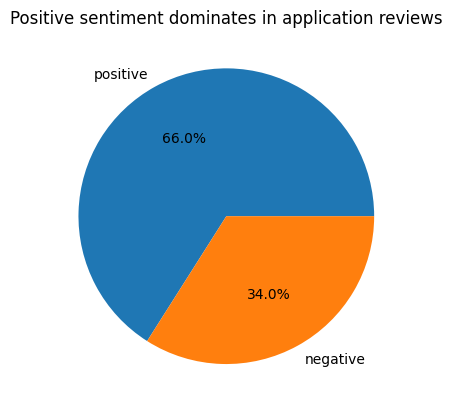

In [12]:
plt.pie(df["polarity"].value_counts(), labels=df["polarity"].value_counts().index, autopct='%1.1f%%')
plt.title("Positive sentiment dominates in application reviews")
plt.show()

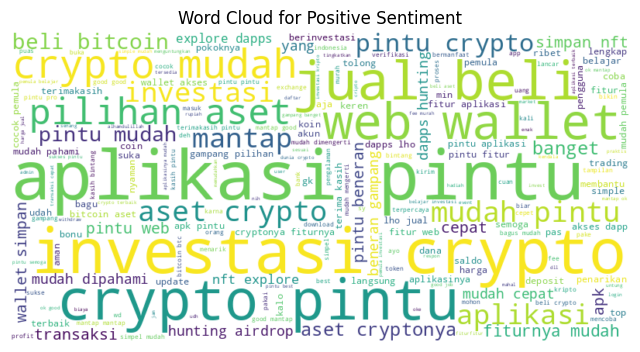

In [13]:
positive_reviews = df[df["polarity"] == "positive"]["text_sentences"].str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment")
plt.show()

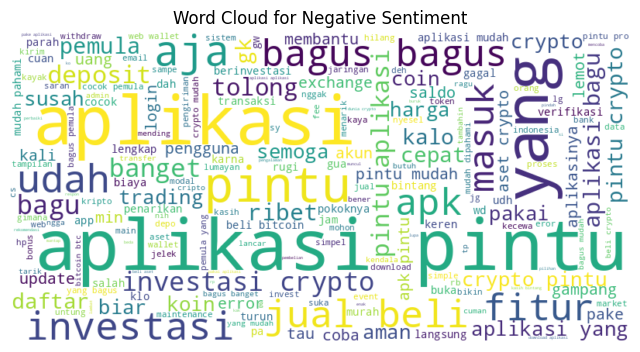

In [14]:
negative_reviews = df[df["polarity"] == "negative"]["text_sentences"].str.cat(sep=' ')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Sentiment")
plt.show()

In [15]:
def split_text(text):
    return text.split()

freq_positive = Counter()
freq_negative = Counter()

for _, row in df.iterrows():
    if row["polarity"] == "positive":
        words = split_text(row["text_sentences"])
        freq_positive.update(words)
    elif row["polarity"] == "negative":
        words = split_text(row["text_sentences"])
        freq_negative.update(words)


print("Top 10 Positive Words:")
print(freq_positive.most_common(10))

print("Top 10 Negative Words:")
print(freq_negative.most_common(10))

Top 10 Positive Words:
[('pintu', 5985), ('mudah', 3787), ('crypto', 2957), ('aplikasi', 2387), ('investasi', 1814), ('fitur', 1327), ('aset', 1271), ('pemula', 1239), ('mantap', 1185), ('cepat', 1048)]
Top 10 Negative Words:
[('aplikasi', 3841), ('pintu', 3193), ('bagus', 1627), ('yang', 1491), ('crypto', 1345), ('mudah', 1072), ('investasi', 784), ('pemula', 760), ('beli', 630), ('banget', 606)]


In [48]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df["text_sentences"], df["polarity"], test_size=0.2, random_state=42)

tfidf_svm = TfidfVectorizer(max_features=1000, min_df=17, max_df=0.8)

X_train_tfidf_svm = tfidf_svm.fit_transform(X_train1)
X_test_tfidf_svm = tfidf_svm.transform(X_test1)

model1 = SVC(random_state=42)

model1.fit(X_train_tfidf_svm, y_train1)

y_pred_train1 = model1.predict(X_train_tfidf_svm)
y_pred_test1 = model1.predict(X_test_tfidf_svm)

accuracy_train1 = model1.score(X_train_tfidf_svm, y_train1)
accuracy_test1 = model1.score(X_test_tfidf_svm, y_test1)

print("Test 1: SVM + TF-IDF + 80/20")
print(f"Train Accuracy: {accuracy_train1:.4f}")
print(f"Test Accuracy: {accuracy_test1:.4f}")

Test 1: SVM + TF-IDF + 80/20
Train Accuracy: 0.9833
Test Accuracy: 0.9231


In [49]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df["text_sentences"], df["polarity"], test_size=0.3, random_state=42)

tfidf_nb = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8)

X_train_tfidf_nb = tfidf_nb.fit_transform(X_train2)
X_test_tfidf_nb = tfidf_nb.transform(X_test2)

model2 = BernoulliNB()

model2.fit(X_train_tfidf_nb, y_train2)

y_pred_train2 = model2.predict(X_train_tfidf_nb)
y_pred_test2 = model2.predict(X_test_tfidf_nb)

accuracy_train2 = model2.score(X_train_tfidf_nb, y_train2)
accuracy_test2 = model2.score(X_test_tfidf_nb, y_test2)
print("Test 2: Naive Bayes + TF-IDF + 70/30")
print(f"Train Accuracy: {accuracy_train2:.4f}")
print(f"Test Accuracy: {accuracy_test2:.4f}")

Test 2: Naive Bayes + TF-IDF + 70/30
Train Accuracy: 0.8296
Test Accuracy: 0.8140


In [32]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.95:
            print("\nReached 95% accuracy, stopping training!")
            self.model.stop_training = True

callbacks = MyCallback()

In [45]:
texts = df["text_sentences"].values
labels = df["polarity"].map({"positive": 1, "negative": 0}).values

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train, padding='post')
padded_test = pad_sequences(sequences_test, padding='post', maxlen=padded_train.shape[1])

print(f"Shape of train data: {padded_train.shape}")
print(f"Shape of test data: {padded_test.shape}")

model = tf.keras.Sequential([
    Embedding(input_dim=1000, output_dim=128),
    LSTM(128, return_sequences=True),
    LSTM(164, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(padded_train, y_train, epochs=10, batch_size=32, validation_data=(padded_test, y_test), callbacks=[callbacks])

print("Test3: LSTM + Embedding + 80/20")
print(f"Train Accuracy: {model.evaluate(padded_train, y_train)[1]:.4f}")
print(f"Test Accuracy: {model.evaluate(padded_test, y_test)[1]:.4f}")

Shape of train data: (15183, 72)
Shape of test data: (3796, 72)
Epoch 1/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6598 - loss: 0.6423 - val_accuracy: 0.6502 - val_loss: 0.6476
Epoch 2/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6660 - loss: 0.6384 - val_accuracy: 0.6502 - val_loss: 0.6480
Epoch 3/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6617 - loss: 0.6406 - val_accuracy: 0.6502 - val_loss: 0.6475
Epoch 4/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.6654 - loss: 0.6377 - val_accuracy: 0.6502 - val_loss: 0.6391
Epoch 5/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6605 - loss: 0.6351 - val_accuracy: 0.6502 - val_loss: 0.6457
Epoch 6/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6614 - loss: 0.6381 - val_accuracy: 0.6502 - val_loss: 0.6447
Epoch 7/10
475/475 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6684 - loss: 0.6327 - val_accuracy: 0.6502 - val_loss: 0.6441
Epoch 8/10
475/475 ━━━━━━━━━━━

In [66]:
new_texts = ["mudah digunakan", "aplikasi mengalami error"]

new_text_tfidf = tfidf_svm.transform(new_texts)

new_predictions = model1.predict(new_text_tfidf)

for text, pred in zip(new_texts, new_predictions):
    print(f"Teks: \"{text}\" → Prediksi: {pred}")

Teks: "mudah digunakan" → Prediksi: positive
Teks: "aplikasi mengalami error" → Prediksi: negative
